In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import MNIST 

In [2]:
dataset = MNIST(root='assets/', train=True , download=True , transform=torchvision.transforms.ToTensor())

In [3]:
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: assets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
image , label = dataset[0]
image.shape , label

(torch.Size([1, 28, 28]), 5)

## I am planning on 50000 training images and 10000 validation images. Along with that 10000 images for testing the model.

In [5]:
from torch.utils.data import random_split

In [6]:
trainDataSet , validDataSet = random_split(dataset , [50000 , 10000])
len(trainDataSet) , len(validDataSet)

(50000, 10000)

In [12]:
test_dataset = MNIST(root='assets/' , train=False , download=True , transform=torchvision.transforms.ToTensor())
len(test_dataset)

10000

## Lets check a few images from the dataset

label:  6


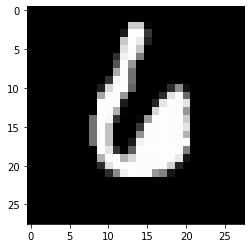

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

image , label = trainDataSet[100]
print("label: " , label)
plt.imshow(image[0,:,:] , cmap='gray')
plt.show()

## We will be passing our data in batches so we have to split train and valid dataset into batches

In [9]:
from torch.utils.data import DataLoader

batch_size = 64

trainBatch = DataLoader(trainDataSet , batch_size , shuffle=True)
validBatch = DataLoader(validDataSet , batch_size , shuffle=True)

In [10]:
#Lets check for 1 batch
for imageBatch , labelsBatch in trainBatch:
    print(imageBatch.shape)
    print(labelsBatch.shape)
    break

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Let's create our model

In [6]:
input_shape = 1*28*28
hidden_shape = 512
output_shape = 10

In [7]:
def accuracy(preds , labels):
    maxprob , predlabel = torch.max(preds , dim=1)
    difference = predlabel - labels
    count = 0
    for i in difference:
        if i == 0:
            count+=1
    return count*100/preds.size()[0]

In [8]:
import torch.nn.functional as F
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel , self ).__init__()
        self.fc1 = nn.Linear(input_shape , hidden_shape)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_shape , output_shape)

    def forward(self , images):
        images = images.reshape(-1 , input_shape)
        hidden = self.fc1(images)
        relu = self.relu(hidden)
        output = self.fc2(relu)
        return output

    def training_step(self , imagebatch , labelbatch):
        #imagebatch = imagebatch.reshape(-1 , 784)
        output = self(imagebatch)
        loss = F.cross_entropy(output , labelbatch)
        return loss

    def validation_per_batch(self , batch):
        images , labels = batch
        preds = self(images)
        loss = F.cross_entropy(preds , labels)
        acc = accuracy(preds , labels)
        return { 'val_loss':loss , 'val_acc':acc }
    
    def validation_epoch_end(self , measurements):
        losses = [x['val_loss'] for x in measurements]
        avg_loss = np.sum(losses)/len(losses)
        accuracies = [x['val_acc'] for x in measurements]
        avg_acc = np.sum(accuracies)/len(accuracies)
        return {'val_loss':avg_loss , 'val_acc':avg_acc}

    def log_output(self, epoch, result):
        print("EPOCH[{0}]  Val_loss: {1}  Val_acc: {2}".format(epoch, result['val_loss'] , result['val_acc'] ))

model = MNISTModel()

In [9]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.0154,  0.0089,  0.0099,  ..., -0.0266,  0.0138, -0.0118],
         [-0.0326,  0.0292, -0.0007,  ..., -0.0239, -0.0096, -0.0128],
         [ 0.0079, -0.0016,  0.0277,  ..., -0.0205, -0.0260, -0.0321],
         ...,
         [-0.0007, -0.0159, -0.0115,  ...,  0.0305,  0.0225, -0.0099],
         [-0.0111,  0.0143, -0.0298,  ..., -0.0277,  0.0248,  0.0139],
         [-0.0048,  0.0038, -0.0052,  ..., -0.0182,  0.0032,  0.0201]],
        requires_grad=True),
 Parameter containing:
 tensor([ 1.9696e-02, -3.3263e-02, -2.9376e-02,  9.1562e-03,  2.0332e-03,
         -1.3934e-02, -1.2232e-02,  2.4662e-02, -1.3480e-02,  2.3772e-02,
         -2.1393e-03,  2.9916e-02, -2.7851e-02,  2.1727e-02,  3.0073e-02,
         -1.5866e-02,  5.2338e-03, -3.4744e-02, -1.8074e-02, -3.8836e-03,
         -1.2633e-02, -1.3437e-02,  1.7075e-02,  1.5408e-02,  1.5503e-02,
         -2.1920e-02,  2.6551e-03, -1.2974e-02,  2.8176e-02,  2.8753e-02,
          6.8816e-04, -1.3060e-02, -2.14

## Start training

In [15]:
def evaluate(validBatch):
    outputs = [model.validation_per_batch(batch) for batch in validBatch]
    return model.validation_epoch_end(outputs)


def fit(model, epoches , trainBatch , validBatch , lr , opt_fn=torch.optim.SGD):
    history = []
    opt = opt_fn(model.parameters() , lr)
    for epoch in range(epochs):
        for imageBatch , labelsBatch in trainBatch:
            #imagebatch , labelbatch = batch
            loss = model.training_step(imageBatch , labelsBatch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        result = evaluate(validBatch)
        model.log_output(epoch , result)
        history.append(result)
    return history



In [16]:
import numpy as np
result0 = evaluate(validBatch)
result0

{'val_loss': tensor(2.2999, grad_fn=<DivBackward0>), 'val_acc': 9.375}

In [17]:
epochs = 50
lr = 1e-3

history = fit(model, epochs , trainBatch , validBatch , lr)

EPOCH[0]  Val_loss: 2.110050916671753  Val_acc: 63.42555732484077
EPOCH[1]  Val_loss: 1.8796898126602173  Val_acc: 72.24323248407643
EPOCH[2]  Val_loss: 1.6066116094589233  Val_acc: 75.71656050955414
EPOCH[3]  Val_loss: 1.3401952981948853  Val_acc: 78.42356687898089
EPOCH[4]  Val_loss: 1.1233428716659546  Val_acc: 80.86186305732484
EPOCH[5]  Val_loss: 0.9646518230438232  Val_acc: 82.37460191082802
EPOCH[6]  Val_loss: 0.8500819206237793  Val_acc: 83.36982484076434
EPOCH[7]  Val_loss: 0.7652959227561951  Val_acc: 84.30533439490446
EPOCH[8]  Val_loss: 0.7024936676025391  Val_acc: 84.97213375796179
EPOCH[9]  Val_loss: 0.6530417799949646  Val_acc: 85.54936305732484
EPOCH[10]  Val_loss: 0.6128939986228943  Val_acc: 86.24601910828025
EPOCH[11]  Val_loss: 0.5809138417243958  Val_acc: 86.5843949044586
EPOCH[12]  Val_loss: 0.5574306845664978  Val_acc: 86.90286624203821
EPOCH[13]  Val_loss: 0.5338557362556458  Val_acc: 87.17157643312102
EPOCH[14]  Val_loss: 0.5135623812675476  Val_acc: 87.6393312

In [18]:
history[0]['val_acc']

63.42555732484077

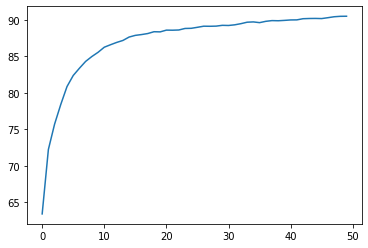

In [19]:
plt.plot([x['val_acc'] for x in history])
plt.show()

In [20]:
history

[{'val_loss': tensor(2.1101, grad_fn=<DivBackward0>),
  'val_acc': 63.42555732484077},
 {'val_loss': tensor(1.8797, grad_fn=<DivBackward0>),
  'val_acc': 72.24323248407643},
 {'val_loss': tensor(1.6066, grad_fn=<DivBackward0>),
  'val_acc': 75.71656050955414},
 {'val_loss': tensor(1.3402, grad_fn=<DivBackward0>),
  'val_acc': 78.42356687898089},
 {'val_loss': tensor(1.1233, grad_fn=<DivBackward0>),
  'val_acc': 80.86186305732484},
 {'val_loss': tensor(0.9647, grad_fn=<DivBackward0>),
  'val_acc': 82.37460191082802},
 {'val_loss': tensor(0.8501, grad_fn=<DivBackward0>),
  'val_acc': 83.36982484076434},
 {'val_loss': tensor(0.7653, grad_fn=<DivBackward0>),
  'val_acc': 84.30533439490446},
 {'val_loss': tensor(0.7025, grad_fn=<DivBackward0>),
  'val_acc': 84.97213375796179},
 {'val_loss': tensor(0.6530, grad_fn=<DivBackward0>),
  'val_acc': 85.54936305732484},
 {'val_loss': tensor(0.6129, grad_fn=<DivBackward0>),
  'val_acc': 86.24601910828025},
 {'val_loss': tensor(0.5809, grad_fn=<DivBa

In [40]:
torch.save(model.state_dict() , "savedModels/MNIST_FeedForward.pth")

In [10]:
model = MNISTModel()
trained_params = torch.load('savedModels/MNIST_FeedForward.pth')
model.load_state_dict(trained_params)
print(list(model.parameters()))

[Parameter containing:
tensor([[-0.0021,  0.0155, -0.0197,  ..., -0.0297, -0.0281,  0.0164],
        [-0.0022, -0.0065, -0.0254,  ...,  0.0165,  0.0167,  0.0178],
        [-0.0030, -0.0245, -0.0116,  ..., -0.0242, -0.0225,  0.0269],
        ...,
        [-0.0052, -0.0165, -0.0195,  ...,  0.0144, -0.0304, -0.0183],
        [ 0.0188,  0.0223, -0.0153,  ..., -0.0128,  0.0242, -0.0166],
        [ 0.0242,  0.0158,  0.0005,  ..., -0.0106,  0.0184, -0.0059]],
       requires_grad=True), Parameter containing:
tensor([ 3.4974e-02, -2.3049e-02,  5.5575e-02,  6.5393e-02,  3.8538e-02,
        -4.1116e-02, -1.0240e-03,  1.8500e-02, -5.9876e-03, -2.9580e-02,
        -6.3800e-03,  3.5538e-02,  4.3719e-02, -4.3764e-03,  2.3145e-02,
        -1.0096e-02, -4.7295e-03, -2.3412e-03,  4.7253e-03, -4.5834e-02,
         6.3987e-03, -2.3744e-02, -1.6357e-02, -9.5095e-03,  3.3216e-02,
         5.9856e-02,  2.5141e-02,  6.1035e-03,  5.0497e-02,  6.3214e-02,
         5.5985e-02,  4.9159e-02,  3.1592e-02,  2.4087e

9


torch.Size([1, 28, 28])

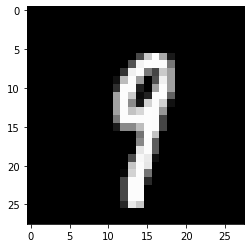

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
image , label = test_dataset[1439]
print(label)
plt.imshow(image[0,:,:] , cmap="gray")
image.shape

In [15]:
image.unsqueeze(0).shape

torch.Size([1, 1, 28, 28])

In [16]:
print(image.shape)
yb = model(image)
_ , preds = torch.max(yb , dim=1)
print(preds.item())

torch.Size([1, 28, 28])
9
